In [1]:
%run 0-Base.ipynb

In [2]:
SOURCE_PATH = f'{DATA_PATH}/5-scaled'

Define a dataset:

In [3]:
from torch.utils.data import Dataset

class EloDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        if self.y is not None:
            return self.X[index], self.y[index]
        else:
            return self.X[index]

Define *train* and *valid* data loaders:

In [4]:
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader

X = np.load(f'{SOURCE_PATH}/train/X.npy').astype(np.float32)
y = np.load(f'{SOURCE_PATH}/train/y.npy').astype(np.float32)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=13)

train_dataset = EloDataset(X_train, y_train)
valid_dataset = EloDataset(X_valid, y_valid)

kwargs = dict(shuffle=True)

train_loader = DataLoader(train_dataset, batch_size=2**5,  **kwargs)
valid_loader = DataLoader(valid_dataset, batch_size=2**13, **kwargs)

Define a device that will be used for training / evaluation:

In [5]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from torch import nn

import torch.nn.functional as F

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.old_transactions_lstm = nn.LSTM(input_size=29,
                                             hidden_size=64,
                                             num_layers=2,
                                             dropout=0.5,
                                             batch_first=True)

        self.new_transactions_lstm = nn.LSTM(input_size=29,
                                             hidden_size=64,
                                             num_layers=2,
                                             dropout=0.5,
                                             batch_first=True)

        self.tail = nn.Sequential(nn.Linear(128, 64),
                                  nn.BatchNorm1d(64),
                                  nn.PReLU(),
                                  nn.Dropout(),
                                  # ---
                                  nn.Linear(64, 32),
                                  nn.BatchNorm1d(32),
                                  nn.PReLU(),
                                  nn.Dropout(),
                                  # ---
                                  nn.Linear(32, 1))

    def forward(self, X):
        out1, _ = self.old_transactions_lstm(X[:,   :-3])
        out2, _ = self.new_transactions_lstm(X[:, -3:  ])

        # get only the last item
        # see many-to-one LSTM arch
        out1 = out1[:, -1]
        out2 = out2[:, -1]

        out = torch.cat((out1, out2), dim=1)
        out = self.tail(out)
        return out

In [7]:
from torch import optim
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

model = Regressor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=5e-4)

n_epochs = 35
valid_loss_min = np.Inf
writer = SummaryWriter('runs/origin')

for epoch in tqdm(range(n_epochs)):
    cum_train_loss = 0.
    cum_valid_loss = 0.

    for X, y in tqdm(train_loader):
        X, y = X.to(device), y.to(device)

        model.train()

        # ZERO PREVIOUS GRADS
        optimizer.zero_grad()

        y_pred = model.forward(X)
        assert y.shape == y_pred.shape
        loss = criterion(y_pred, y)

        loss.backward()
        optimizer.step()

        cum_train_loss += loss.item()

    model.eval()

    with torch.no_grad():
        for X, y in valid_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model.forward(X)
            assert y.shape == y_pred.shape
            loss = criterion(y_pred, y)

            cum_valid_loss += loss.item()

    train_loss = (cum_train_loss / X_train.shape[0]) ** 0.5
    valid_loss = (cum_valid_loss / X_valid.shape[0]) ** 0.5

    if valid_loss < valid_loss_min:
        print('Validation loss decreased: %.5f => %.5f | Saving model...' % (valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

    writer.add_scalars('loss', dict(train_loss=train_loss, valid_loss=valid_loss), epoch)


Validation loss decreased: inf => 3.74277 | Saving model...



Validation loss decreased: 3.74277 => 3.72046 | Saving model...



Validation loss decreased: 3.72046 => 3.71653 | Saving model...



Validation loss decreased: 3.71653 => 3.71114 | Saving model...



Validation loss decreased: 3.71114 => 3.70209 | Saving model...



Validation loss decreased: 3.70209 => 3.70098 | Saving model...



Validation loss decreased: 3.70098 => 3.69159 | Saving model...



Validation loss decreased: 3.69159 => 3.68957 | Saving model...



Validation loss decreased: 3.68957 => 3.68529 | Saving model...



Validation loss decreased: 3.68529 => 3.68480 | Saving model...



Validation loss decreased: 3.68480 => 3.68381 | Saving model...



Validation loss decreased: 3.68381 => 3.68077 | Saving model...


Validation loss: 3.68077


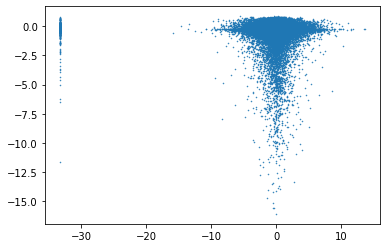

In [8]:
criterion = nn.MSELoss(reduction='sum')

model = Regressor().to(device).eval()
model_state_dict = torch.load('model.pt')
model.load_state_dict(model_state_dict)

y_valid_pred = []
cum_valid_loss = 0.

with torch.no_grad():
    for X, y in valid_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model.forward(X)
        y_valid_pred.append(y_pred.cpu().numpy())

        assert y.shape == y_pred.shape
        loss = criterion(y_pred, y)

        cum_valid_loss += loss.item()

y_valid_pred = np.concatenate(y_valid_pred)
assert y_valid.shape == y_valid_pred.shape

valid_loss = (cum_valid_loss / X_valid.shape[0]) ** 0.5
print('Validation loss: %.5f' % valid_loss)

plt.scatter(y_valid, y_valid_pred, s=0.25);

In [9]:
X_test, y_test = np.load(f'{SOURCE_PATH}/test/X.npy').astype(np.float32), []

test_dataset = EloDataset(X_test)

test_loader = DataLoader(test_dataset, batch_size=2**13)

with torch.no_grad():
    for X in test_loader:
        X = X.to(device)
        y_pred = model.forward(X)
        y_test.append(y_pred.cpu().numpy())

y_test = np.concatenate(y_test)
display(y_test)

array([[-0.41455686],
       [-1.5511522 ],
       [ 0.6666914 ],
       ...,
       [-0.62688553],
       [-0.40432942],
       [-0.07339004]], dtype=float32)

In [10]:
submission_df = pd.read_csv(f'{DATA_PATH}/raw/sample_submission.csv').sort_values('card_id')
submission_df.target = y_test
display(submission_df)

submission_df.to_csv('submission.csv', index=False)

,card_id,target
9030,C_ID_0001238066,-0.414557
48429,C_ID_0001793786,-1.551152
59611,C_ID_00024e244b,0.666691
22596,C_ID_0002709b5a,-0.288003
65546,C_ID_000298032a,-0.051680
...,...,...
57732,C_ID_fffd337484,-2.409464
19017,C_ID_fffd345048,-0.295072
39078,C_ID_fffd943b91,-0.626886
49255,C_ID_ffff1d9928,-0.404329
